In [100]:
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     - -------------------------------------- 1.6/33.5 MB 10.5 MB/s eta 0:00:04
     ----- ---------------------------------- 4.5/33.5 MB 12.8 MB/s eta 0:00:03
     -------- ------------------------------- 7.3/33.5 MB 13.3 MB/s eta 0:00:02
     ----------- ---------------------------- 9.7/33.5 MB 12.6 MB/s eta 0:00:02
     -------------- ------------------------ 12.3/33.5 MB 12.3 MB/s eta 0:00:02
     ------------------ -------------------- 15.7/33.5 MB 13.0 MB/s eta 0:00:02
     --------------------- ----------------- 18.9/33.5 MB 13.4 MB/s eta 0:00:02
     ------------------------ -------------- 21.0/33.5 MB 12.7 MB/s eta 0:00:01
     ---------------------------- ---------- 24.4/33.5 MB 13.2 MB/s eta 0:00:01
     -------------------------------- ------ 28.0/33.5 MB 13.7 M

In [119]:
import pandas as pd
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

nlp = spacy.load('en_core_web_md')
nltk.download('vader_lexicon')
nltk.download('stopwords')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
#ZAD1
data = pd.read_csv('sample.csv')

data['toxicity_label'] = data['target'].apply(lambda text: 'toxic' if text >= 0.5 else 'non-toxic')

In [128]:
positive_emotions = nlp("happy joyful sincere excited content peaceful delighted cheerful optimistic")
negative_emotions = nlp("angry sad upset frustrated annoyed disappointed bitter resentful hostile")

In [129]:
stop_words = set(stopwords.words('english'))

In [130]:
def preprocess_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    return " ".join(tokens)

In [131]:
data['comment_text'] = data['comment_text'].apply(preprocess_text)

In [122]:
def analyze_sentiment(text):
    toxicity_score = sia.polarity_scores(text)
    if toxicity_score['compound'] >= 0.05:
        return 'positive'
    elif toxicity_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [134]:
data['toxicity'] = data['comment_text'].apply(analyze_sentiment)

In [104]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['comment_text'])

In [105]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [106]:
data['Cluster'] = kmeans.labels_

In [107]:
X = data['Cluster'].value_counts()

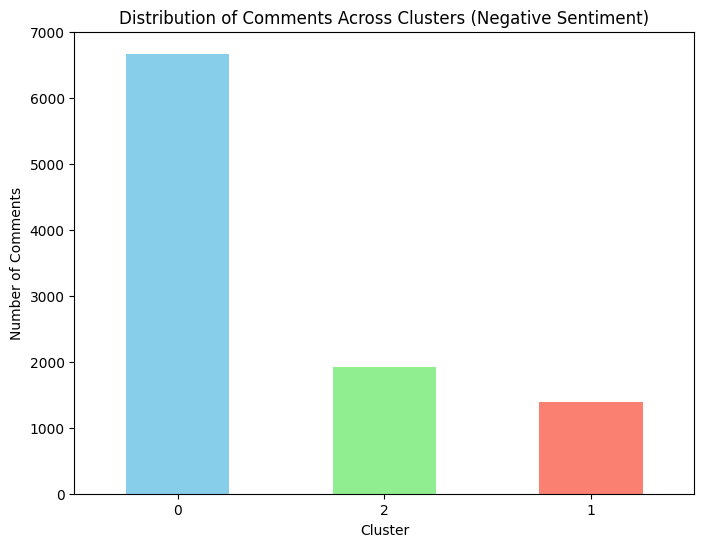

In [108]:
plt.figure(figsize=(8, 6))
X.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribution of Comments Across Clusters (Negative Sentiment)')
plt.xlabel('Cluster')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.show()

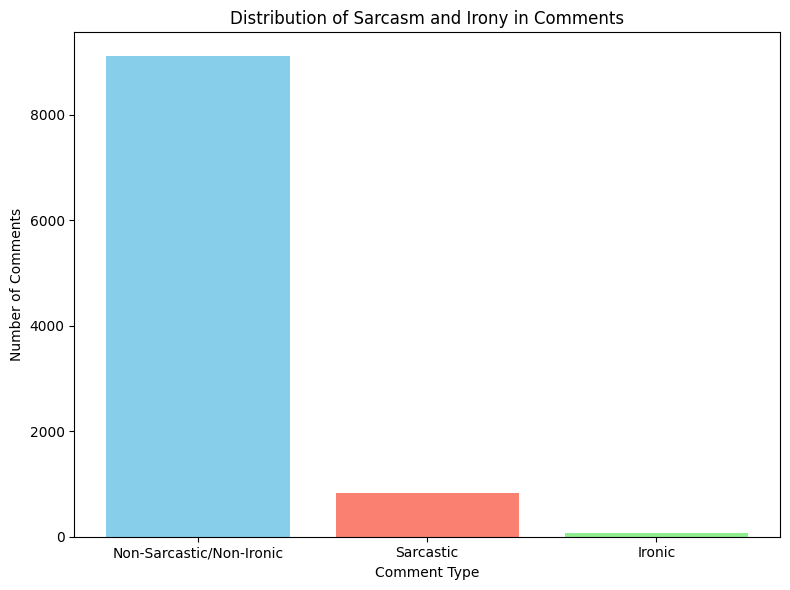

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Extract features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(data['comment_text'])

# Step 2: Perform clustering using KMeans
num_clusters = 5  # Number of clusters to identify (adjust as needed)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Add the cluster labels to the dataset
data['cluster'] = kmeans.labels_

def detect_irony_with_sentiment(text):
    sentiment = sia.polarity_scores(text)
    if sentiment['pos'] > 0.4 and sentiment['neg'] > 0.4:  # High positive and negative sentiment
        return True
    return False

data['irony'] = data['comment_text'].apply(detect_irony_with_sentiment)

# Define markers or rules for irony detection
irony_markers = [
    'oh really', 'how surprising', 'of course not', 'what a surprise', 
    'unexpected', 'how ironic', 'as if', 'so unexpected', 'right, because that works'
]

def detect_irony(text):
    for marker in irony_markers:
        if marker in text:
            return True
    return False

# Apply irony detection
data['irony'] = data['comment_text'].apply(detect_irony)

# Summarize sarcasm, irony, and other comments
sarcasm_count = data['sarcasm'].sum()
irony_count = data['irony'].sum()
non_sarcastic_or_ironic_count = len(data) - sarcasm_count - irony_count

# Create labels and counts
labels = ['Non-Sarcastic/Non-Ironic', 'Sarcastic', 'Ironic']
counts = [non_sarcastic_or_ironic_count, sarcasm_count, irony_count]

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sarcasm and Irony in Comments')
plt.xlabel('Comment Type')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()